<h1>Poles/Zeros/Gain from Look-Up Tables (Prototyping)</h1>

## Problem Statement

The IRIS metadata archiving process had a strong preference for pole-zero ('zpk') representations of analog filters.  However, calibrations of many MT instruments are characterized in the form of frequency sweeps, and manufacturer's calibrations are often provided in terms of tables of frequency, with amplitude and phase responses ('fap'). 

Thus we are faced with the problem of expressing a generic _fap_ instrument resposne in the _zpk_ format.

## Inverse Problem Setup

Starting with the classic inversion model notation:

$\bf{d} = \bf{Gm}$

$\bf{d}$: The "data" in the the 'fap' table.  This is simply a set of $N$ ordered pairs, $\{(f_1, x_1), (f_2, x_2), ... (f_N, x_N)\}$ where $f_i \in \mathbb{R}^+$ and $x_i \in \mathbb{C}$

$\bf{G}$: The function relating the data and the model can take on several parameterizations.  One parameterization is as a ratio of (possibly complex-valued) polynomials but with only real-valued coefficients.  We apply a change of notation as the data-to-model relationship denoted above as $\bf{G}$ is more commonly referred to in signal processing as $h(s)$ , thus $h(s) \leftarrow \bf{G}(s)$ 

$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} $

Where the Laplace variable _s_  = *j* $\omega$


$\bf{m}$:  Using the above parameterization $\bf{m}$ would be the set of $m + n + 2$ coefficients ${a_0, a_1, ...a_m, b_0, b_1, ... b_n}$ with $a_i, b_i \in \mathbb{R}$

<br>

The coefficients in the numerator and denominator polynomials in the Laplace domain representation of the filter are real. They typically correspond to values of circuit parameters resistance, capacitance, inductance, etc. in analog EE applications. This means that these polynomials factor completely over the complex plane and moreover, the roots are either real or occur in complex-conjugate pairs.
<br>
<br>


Factoring $h(s)$ on top and bottom yields the form:

$ \displaystyle h (s) = k  \frac{(s-z_1)(s-z_2)...(s-z_m) }{(s-p_1)(s-p_2)...(s-p_n)} $

There are well defined transformations between these representations and they are available through _scipy.signal.tf2zpk_ or _zpk2tf_.


### Recent Activity in PZ-fitting

Ben Murphy tried a variety of methods to solve this problem but invariably wound up encountering poles and zeros (roots) that did not obey the principle of complex-conjugate roots, and  sometimes poles on the right hand side of the plane, and or k values that were complex-valued.  The complex k values are particularly concerning because IRIS does not provide support for complex-valued k $-$ it is just one double-precision number.  

The reason for these issues deserves some analysis but at a high level seems to be due to parameterizations that ultimately wound up searching complex-valued spaces for soltuions.

Karl tried some variants on Ben's methods which involved some regularization functions that penalized non-conjugate root pairs, and imaginary parts of k, but these never matured so their value is questionable.

It seems like we should be able to use a numeric method to solve in the real valued form (even though the evaluation of the TF is Complex, the coefficients are real) and then extract the zpk afterwards.  Following is an example of a numeric solution.





In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from matplotlib.gridspec import GridSpec
from pathlib import Path
from scipy import signal
from scipy.optimize import minimize

from aurora.sandbox.plot_helpers import plot_complex_response
from aurora.sandbox.plot_helpers import plot_response_pz

# from regularization_function_development import add_regularization_term 
# from regularization_function_development import get_pz_regularization

# %matplotlib inline


In [2]:
DEG2RAD = np.pi/180

## Load the data from data repo

In [7]:
calibration_file_path = Path().cwd().joinpath("mt_examples", "notebooks", "mt_metadata", "Lemi-039_N131.cal")

df = pd.read_csv(calibration_file_path, skiprows=3, delimiter='\t')
column_labels = ['frequency', 'amplitude_x', 'phase_x', 'amplitude_y', 'phase_y', 'amplitude_z', 'phase_z']
columns_map = dict(zip(df.columns, column_labels))
df = df.rename(columns=columns_map)


## Preliminary Response Curve


In the following, the variables are sometimes prefixed with an $x$. The reason for this is that the LEMI calibration file has columns in the table for $x, y, z$ and in this example we select the $x$ columns for analysis. 

We start by reading the amplitude and phase from the dataframe, and combining them into a single complex-valued response function.

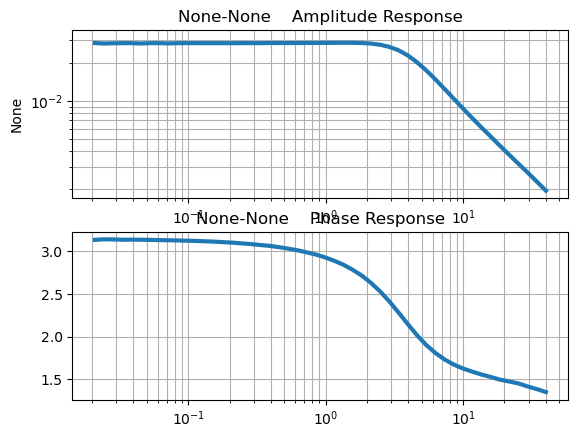

In [8]:
x_phase_radians = np.deg2rad(df['phase_x'])
x_phasor = np.exp(1.J*x_phase_radians) #(np.cos( x_phase_radians)+ 1.j*np.sin(x_phase_radians))
x_complex_response = df['amplitude_x'] * x_phasor
frequencies = df['frequency'].to_numpy()

plot_complex_response(df['frequency'], x_complex_response)

## Estimate the response amplitude in the pass band

In [9]:
nominal_passband_response_amplitude = df['amplitude_x'].iloc[10].mean()
print('nominal_passband_response_amplitude', nominal_passband_response_amplitude)

nominal_passband_response_amplitude 0.02847


## Express in units of deciBels and plot on semilog

In [10]:
amplitude_in_db = 20*np.log10(df['amplitude_x']/nominal_passband_response_amplitude)

Text(0.5, 1.0, 'Amplitude Response of Instrument in dB')

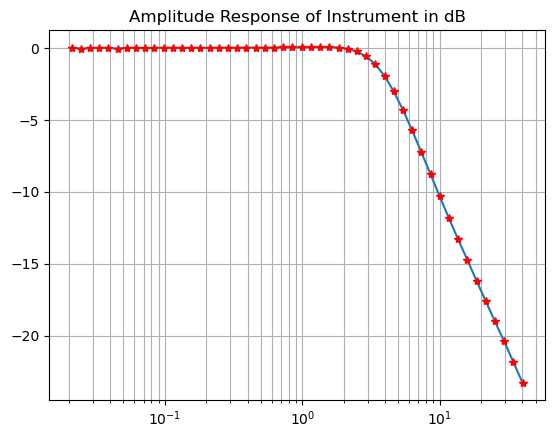

In [11]:
plt.semilogx(df['frequency'], amplitude_in_db)
plt.semilogx(df['frequency'], amplitude_in_db, 'r*')
plt.grid(which='both')
plt.title('Amplitude Response of Instrument in dB')


## Note that the decay is log-linear after about 5Hz

The last 13 points are approximately a straight line on the log plot.  Thus we can fit a line to them and estimate the number of decibels per decade roll-off by the slope of the fit line.

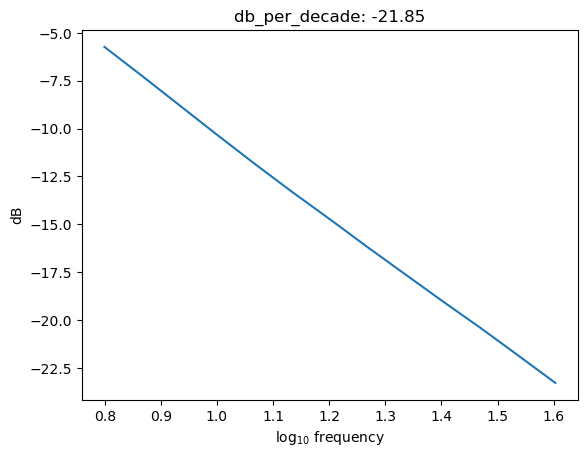

In [12]:
n_asymptotic_log_linear = 13
frq_line = df['frequency'][-n_asymptotic_log_linear:]
ampl_line = df['amplitude_x'][-n_asymptotic_log_linear:]
db_line = amplitude_in_db[-n_asymptotic_log_linear:]
log_f = np.array(np.log10(frq_line))
log_a = np.array(np.log10(ampl_line))
db = np.array(db_line)
db_per_decade = (db[-1]-db[0]) / (log_f[-1]-log_f[0])

plt.plot(log_f, db_line)
plt.xlabel('log$_{10}$ frequency')
plt.ylabel('dB')
plt.title(f"db_per_decade: {db_per_decade:.2f}")
plt.show()

### looks like approximately -20dB/decade, which theoretically corresponds to a single pole.  We obtain a decent fit with one pole, but a better fit with 3poles and one zero.

If we want to optimize we need to add constraints however.  In particular, a regulariization that forces 1: complex poles to be conjugates, and the 'odd' poles to be pure real.  This means modifying the LLSQ process.

If the roll off is ~20dB/ decade then we would expect a 1 pole filter, or at least a filter with one more poles than zeros.

## Optimization of pole-zero fit

Below, a simple numeric optimization is set up that will search for the pole-zero coefficients.  

The steps are:
1. Define global variables needed for optimization
2. Define the objective function
3. Select a method of searching the space

### Global Variables needed for optimization

In the following, some global variables are defined that the objective function needs access to.  These are in all upper-case letters

In [13]:
# fap-table based response function, used to measure misfit
X_COMPLEX_RESPONSE = copy.deepcopy(x_complex_response) 

# define angular frequencies
W = 2*np.pi*frequencies

In [14]:
# Define the number of poles and zeros in the model

# N_ZEROS = 0; N_POLES = 1 #Not great
N_ZEROS = 1; N_POLES = 2 #Good when seeded with 1
# N_ZEROS = 2; N_POLES = 3 #Good when seeded with 3
# N_ZEROS = 3; N_POLES = 4 #not so good

In [15]:
# Seed a random number generator and generate an initial condition
seed_value = 1
np.random.seed(seed_value)
b0 = np.random.rand(N_ZEROS+1)
a0 = np.random.rand(N_POLES+1)

# Define the initial model vector, made of all the polynomial coefficients
MODEL_VECTOR_0 = np.hstack((b0, a0))
#print('MODEL_VECTOR_0',MODEL_VECTOR_0)

### Define the objective function

### Lets try a numerical approach using scipy optimize and some regularization that penalizes deviations from the fundamental theorem of algebra solutions

In [16]:
def objective_function(model_vector, verbose=False):
    """
    This function evaluates the complex-valued response of the poles and zeros using 
    scipy.signal, and then measures the goodness-of-fit by differencing the response 
    from the fap-table generated COMPLEX_RESPONSE
    """
    #unpack the model vector
    bb = model_vector[:N_ZEROS+1]
    aa = model_vector[N_ZEROS+1:]
    
    if verbose:
        print(f"n_zeros = {N_ZEROS}")
        print(f"n_poles = {N_POLES}")
        print(f"numerator:   {bb}")
        print(f"denominator: {aa}")
        
    w, h = signal.freqs(bb, aa, worN=W)
    residual = X_COMPLEX_RESPONSE - h
    misfit = np.sqrt(np.mean(np.abs(residual**2)))
    if verbose:
        print(f"misfit: {misfit:.4f}")
    return misfit

misfit = objective_function(MODEL_VECTOR_0, verbose=True)

n_zeros = 1
n_poles = 2
numerator:   [0.417022   0.72032449]
denominator: [1.14374817e-04 3.02332573e-01 1.46755891e-01]
misfit: 2.4606


### Select the optimization search-method 

In [17]:
#method = 'nelder-mead'
method = 'Powell'
#method = 'CG'
#method = 'Newton-CG' #needs Jacobian

### Solve the optimization problem

In [18]:
res = minimize(objective_function, MODEL_VECTOR_0, method=method, options={'xatol': 1e-10, 'disp': True, })

/jobfs/100078412.gadi-pbs/ipykernel_1173250/3488554344.py:1: OptimizeWarning: Unknown solver options: xatol
  res = minimize(objective_function, MODEL_VECTOR_0, method=method, options={'xatol': 1e-10, 'disp': True, })


Optimization terminated successfully.
         Current function value: 0.000202
         Iterations: 14
         Function evaluations: 1012


### Extract the b's and a's (polynomial coefficients) and convert to Poles and Zeros

In [19]:
bb = res.x[:N_ZEROS+1]
aa = res.x[N_ZEROS+1:]
zpk = signal.TransferFunction(bb, aa).to_zpk()

print(zpk)



ZerosPolesGainContinuous(
array([-37.78764719]),
array([-18.49867054+16.57300946j, -18.49867054-16.57300946j]),
-0.4648829833859917,
dt: None
)


### Take a look at the Model Fit

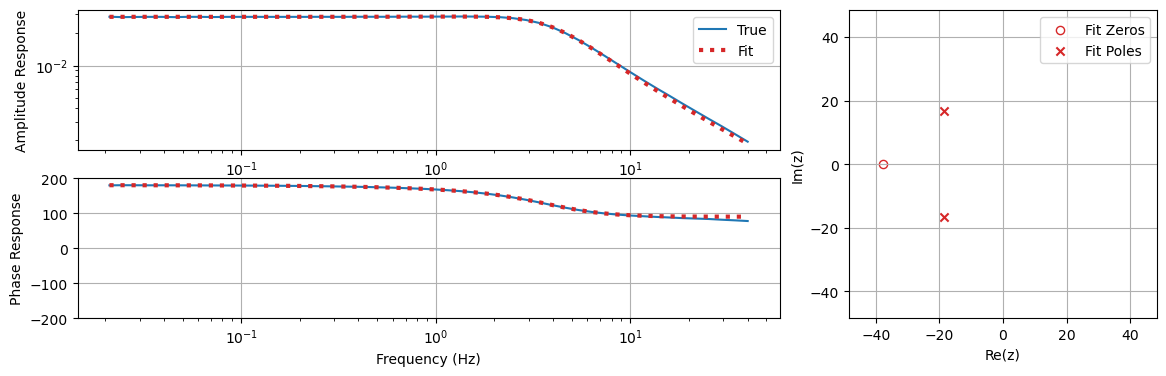

In [20]:
plot_response_pz(w_obs=W, resp_obs=X_COMPLEX_RESPONSE, x_units='frequency', 
              zpk_pred=zpk, w_values=W)

what percent differences are we looking at here?

Text(0, 0.5, 'Percent Difference (%)')

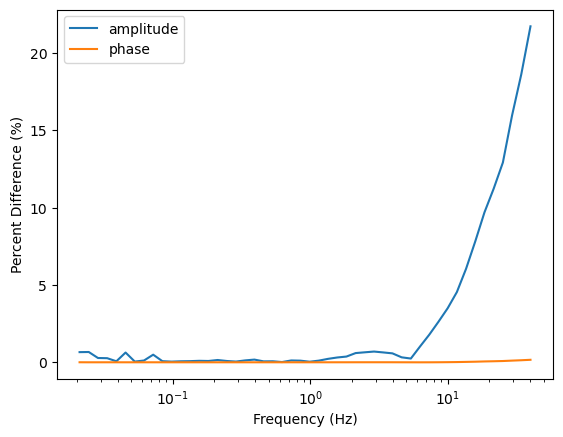

In [21]:
w_pred, resp_pred = signal.freqresp(zpk, w=W)
pct_diff_ampl = np.abs((resp_pred-X_COMPLEX_RESPONSE)/X_COMPLEX_RESPONSE)*100
pct_diff_phase = (np.angle(resp_pred) - np.angle(X_COMPLEX_RESPONSE))/np.angle(X_COMPLEX_RESPONSE)

fig, ax = plt.subplots()
ax.semilogx(W/(2*np.pi), pct_diff_ampl, label="amplitude")
ax.semilogx(W/(2*np.pi), pct_diff_phase, label="phase")
ax.legend()
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Percent Difference (%)")

So, the model agrees to within 1 or 2 percent below 1Hz, and for the LEMI system this is above Nyquist.

## Future Work

We have a numeric method that works "pretty  well" but could use some serious tuning
1. We have analytic expressions so lets get some Jacobians and Hessians and try some of the more classical approaches in scipy.minimize

2. Lets try a bunch of seed values for each optimization and explore the sum RMS misfits.  
3. Do (2) above for a collection of n_poles, n_zeros controls

4. Tidy up supporting codes and make some metrics/reports to use for these fits
5. Move on

####  Note that if we relax the requirement that the poles and zeros are real or conjugate-pairs we can get better fits, but it is a physical solution.  There is some research to be done here.  

If you are interested in exploring more check out Prototyping.ipynb in Ben Murphy's ipynb in iris-mt-scratch repo (iris_mt_scratch/murphy_codes_20210207/system_response_conversion)